## Multi-Armed Bandits

### Intuition & Main Ideas
A **multi-armed bandit** problem is a foundational topic in reinforcement learning. Imagine you have several slot machines (a.k.a. “arms”), each with an unknown probability distribution of payoffs. Your goal is to maximize total reward over many pulls. Each pull yields a single random reward, and you only learn about the arm you just pulled.

**Key Challenge**: Balance **exploration** (trying all arms to find the best) and **exploitation** (consistently playing the arm you believe is best).

### Algorithmic Details
We use a simple **ε-greedy** strategy:
1. **Initialization**: Keep an estimate of the average reward for each arm. Start at 0.
2. **Action Selection**:
   - With probability \( $\epsilon$ \), pick a random arm (exploration).
   - Otherwise, pick the arm with the highest estimated average reward (exploitation).
3. **Update**:
   - Observe the reward from the chosen arm.
   - Update the estimated average reward for that arm.

We run many **plays** (pulls), and track how our estimates evolve. Below, we generate a small animation to visualize the estimated rewards as bar heights for each arm. We also save the first 100 steps of the animation to a GIF.



<IPython.core.display.Javascript object>


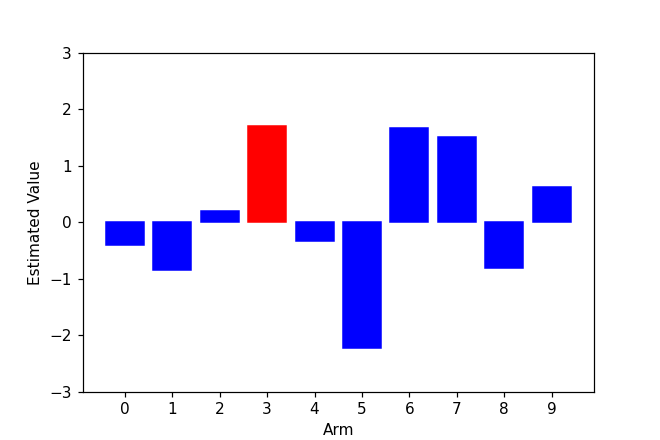

<IPython.core.display.Javascript object>


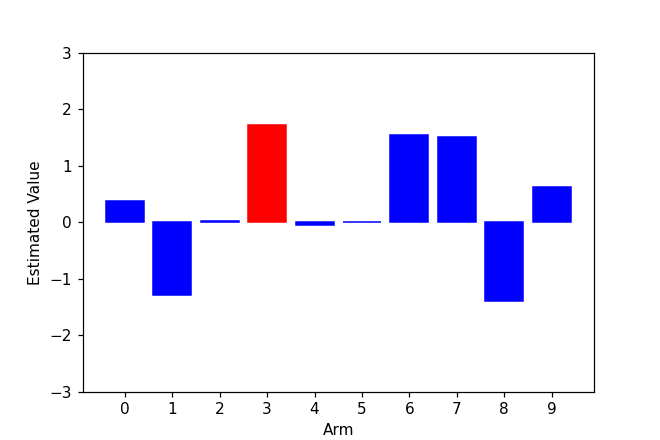

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

%matplotlib notebook

# ---------------------
# Bandit Environment
# ---------------------
class MultiArmedBandit:
    '''
    Multi-armed bandit with N arms, each with a normal reward distribution.
    '''
    def __init__(self, n_arms=10, seed=42):
        '''
        Input:
            n_arms: number of arms
            seed: random seed for reproducibility
        '''
        np.random.seed(seed)
        # Randomly generate each arm's true mean reward
        self.true_means = np.random.normal(loc=0.0, scale=1.0, size=n_arms)
        # Optional: you could also have a distinct std dev per arm if you want
        self.n_arms = n_arms
    
    def pull(self, arm_index):
        '''
        Pull the specified arm and get a reward from a normal distribution.
        '''
        true_mean = self.true_means[arm_index]
        reward = np.random.normal(loc=true_mean, scale=1.0)
        return reward

# ---------------------
# Epsilon-Greedy Training (with frame capture)
# ---------------------
def train_bandit(env, n_steps=200, epsilon=0.1):
    '''
    Train using an epsilon-greedy algorithm, capturing frames for animation.
    Input:
        env: MultiArmedBandit instance
        n_steps: total number of pulls
        epsilon: exploration probability
    Output:
        estimated_values: array of shape (n_arms,) storing final estimates
        frames: list of (estimated_values_copy, chosen_arm) at each step
    '''
    n_arms = env.n_arms
    estimated_values = np.zeros(n_arms)  # Q-values
    counts = np.zeros(n_arms)           # how many times each arm was pulled
    
    frames = []
    
    for step in range(n_steps):
        # Epsilon-greedy selection
        if np.random.rand() < epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(estimated_values)
        
        # Pull arm, observe reward
        reward = env.pull(arm)
        
        # Update counts and estimated values (incremental mean)
        counts[arm] += 1
        alpha = 1.0 / counts[arm]
        estimated_values[arm] += alpha * (reward - estimated_values[arm])
        
        # Capture current estimates (copy for correct snapshot), and chosen arm
        frames.append((estimated_values.copy(), arm))
    
    return estimated_values, frames

# ---------------------
# Animation
# ---------------------
def animate_bandit(frames):
    '''
    Create an animation showing the Q-value estimates as bar heights at each step,
    highlighting the chosen arm in a different color.
    Returns:
      ani: a FuncAnimation object
    '''
    fig, ax = plt.subplots(figsize=(6,4))
    n_arms = len(frames[0][0])
    
    # Initial bar plot
    x_positions = np.arange(n_arms)
    bar_plot = ax.bar(x_positions, frames[0][0], color='blue')
    
    def init():
        ax.set_ylim(-3, 3)  # Adjust if rewards can go beyond [-3,3]
        ax.set_xticks(x_positions)
        ax.set_xlabel("Arm")
        ax.set_ylabel("Estimated Value")
        return bar_plot
    
    def update(frame_data):
        estimated_values, chosen_arm = frame_data
        
        # Update bar heights
        for i, b in enumerate(bar_plot):
            b.set_height(estimated_values[i])
            b.set_color('blue')
        
        # Highlight chosen arm in a different color
        bar_plot[chosen_arm].set_color('red')
        
        return bar_plot
    
    ani = animation.FuncAnimation(
        fig, update, frames=frames, init_func=init, 
        interval=200, blit=False, repeat=False
    )
    
    return ani

# ---------------------
# Main Execution
# ---------------------
def main():
    # Create bandit environment
    env = MultiArmedBandit(n_arms=10, seed=42)
    
    # Train and capture frames
    final_estimates, frames = train_bandit(env, n_steps=200, epsilon=0.1)
    
    # Create animation
    ani = animate_bandit(frames)
#     plt.show()
    
    # Save first 100 frames to a gif
    frames_100 = frames[:100]
    ani_100 = animate_bandit(frames_100)
    ani_100.save('multi_armed_bandit.gif', writer='pillow', fps=5)
    
    return ani

ani = main()
